In [1]:
import numpy as np
from PyQt5.QtWidgets.QMainWindow import corner
from data_tools.query import SunbeamClient
from physics.models.motor import AdvancedMotor
from scipy import optimize
import matplotlib.pyplot as plt
import dill


In [5]:
client = SunbeamClient(api_url="localhost:8080")

try:
    velocity = client.get_file("track_test", "June_8th_Testing", "cleanup", "SpeedMPS").unwrap().data
    actual_power = client.get_file("track_test", "June_8th_Testing", "power", "MotorPower").unwrap().data
    trackIndex = client.get_file("track_test", "June_8th_Testing", "localization", "TrackIndexGPS").unwrap().data
    latitude = client.get_file("track_test", "June_8th_Testing", "localization", "GPSLatitude").unwrap().data
    longitude = client.get_file("track_test", "June_8th_Testing", "localization", "GPSLongitude").unwrap().data
    
    with open("velocity.pkl", "wb") as f:
        dill.dump(velocity, f, protocol=dill.HIGHEST_PROTOCOL)
    
    with open("actual_power.pkl", "wb") as f:
        dill.dump(actual_power, f, protocol=dill.HIGHEST_PROTOCOL)
    
    with open("latitude.pkl", "wb") as f:
        dill.dump(latitude, f, protocol=dill.HIGHEST_PROTOCOL)
        
    with open("longitude.pkl", "wb") as f:
        dill.dump(longitude, f, protocol=dill.HIGHEST_PROTOCOL)
        
    with open("trackIndex.pkl", "wb") as f:
        dill.dump(trackIndex, f, protocol=dill.HIGHEST_PROTOCOL)    

except Exception:
    with open("velocity.pkl", "rb") as f:
        velocity = dill.load(f)
    
    with open("actual_power.pkl", "rb") as f:
        actual_power = dill.load(f)
        
    with open("trackIndex.pkl", "wb") as f:
        trackIndex = dill.load(f, protocol=dill.HIGHEST_PROTOCOL)    
    
    with open("latitude.pkl", "rb") as f:
        latitude = dill.load(f)

    with open("longitude.pkl", "rb") as f:
        longitude = dill.load(f)


In [15]:
from data_tools.collections import TimeSeries

velocity, actual_power, latitude, longitude = TimeSeries.align(velocity, actual_power, latitude, longitude)

In [16]:
from micro_strategy import MicroModelBuilder, load_configs

initial_conditions, environment_config, car_config = load_configs()

micro_builder = (
        MicroModelBuilder()
        .set_environment_config(
            environment_config,
            rebuild_weather_cache=False,
            rebuild_route_cache=False,
            rebuild_competition_cache=False,
        )
        .set_initial_conditions(initial_conditions)
        .set_car_config(car_config)
    )
micro_builder.compile()
_, gis = micro_builder.get()

motor_model = AdvancedMotor(
    vehicle_mass=350,
    road_friction = 0.012,
    tire_radius = 0.2032,
    vehicle_frontal_area = 1.1853,
    drag_coefficient = 0.11609
    
)

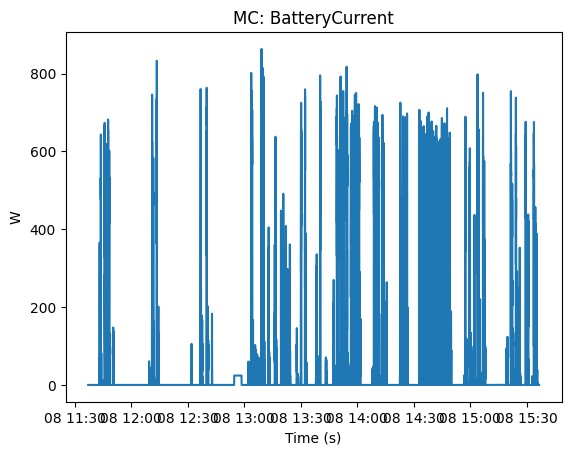

In [70]:
actual_energy = actual_power.promote(np.clip(actual_power * actual_power.period, a_min=0, a_max=None))

actual_energy.plot()

In [72]:
p0 = [0.11609, 0.012, 0.01, 1.0]
bounds = ((0, 0, 0.0, 0), (100, 100, 1000, 10))

# window = slice(10000, 41000, 1)

# trackIndexCleaned = np.nan_to_num(trackIndex).astype(int)[window]
gradients = np.zeros_like(actual_energy)
wind_speeds = np.zeros_like(gradients)
tick = actual_energy.period
coords = np.column_stack((latitude, longitude))
# coords = gis.get_path()[trackIndexCleaned]

def objective(x, drag, friction, cornering, inertial_coefficient):
    motor_model = AdvancedMotor(
        vehicle_mass=350,
        road_friction = friction,
        tire_radius = 0.2032,
        vehicle_frontal_area = 1.1853,
        drag_coefficient = drag,
        cornering_coefficient = cornering,
        inertial_force_coefficient = inertial_coefficient,
        drag2=1.0,
    )
    energy = motor_model.calculate_energy_in(x * 3.6, gradients, wind_speeds, tick, coords)
    
    return energy

popt, pcov = optimize.curve_fit(objective, velocity, actual_energy, p0, bounds=bounds)

121976.34946974865
121976.34946974865
121976.34946974865
121976.53122867314
121976.34946974865
31136.158419597865
31136.158419597865
31136.158419597865
31136.34017852239
31136.158419597865
17482.477954995848
17482.477954995848
17482.477954995848
17482.659713920377
17482.477954995848
10605.243099282618
10605.243099282618
10605.243099282618
10605.424858207147
10605.243099282618
7555.22219757564
7555.22219757564
7555.22219757564
7555.4039565001685
7555.22219757564
6610.716575984688
6610.716575984688
6610.716575984688
6610.898334909215
6610.716575984688
6525.86597133395
6525.86597133395
6525.86597133395
6526.0477302584795
6525.86597133395
6529.182748368761
6529.182748368761
6529.182748368761
6529.364507293292
6529.182748368761


In [80]:
print(
    f"Drag Coefficient: {popt[0]}\n"
    f"Road Friction Coefficient: {popt[1]}\n"
    f"Cornering Coefficient: {popt[2]}\n"
    f"Inertial Force Coefficient: {popt[3]}\n"
)

Drag Coefficient: 0.9016991160970466
Road Friction Coefficient: 0.04608094844278751
Cornering Coefficient: 0.0005352826819914025
Inertial Force Coefficient: 4.0937658196307085



In [74]:
predicted_energy = objective(velocity, *popt)

6529.182748368761


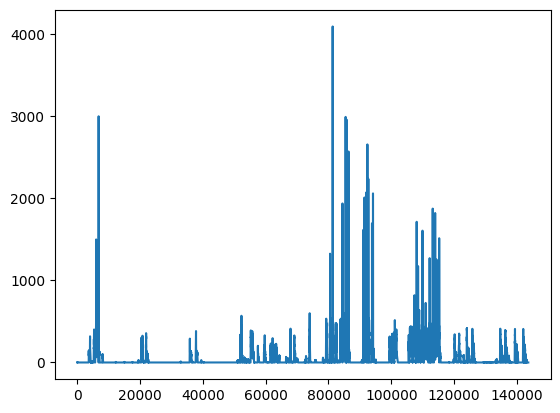

In [75]:
plt.plot(predicted_energy)

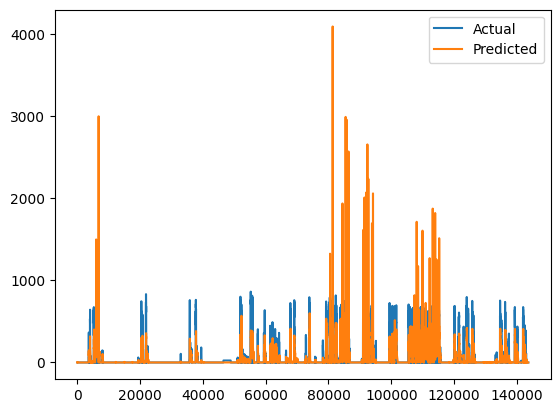

In [77]:
fig, ax = plt.subplots()

show_window = slice(81000, 85000, 1)

ax.plot(actual_energy, label="Actual")
ax.plot(predicted_energy, label="Predicted")
plt.legend()
plt.show()

In [78]:
total_predicted = np.trapezoid(predicted_energy, dx=actual_energy.period)
total_actual = np.trapezoid(actual_energy, dx=actual_energy.period)
print(f"Actual Energy: {total_actual / 1e6} MJ \n Predicted Energy: {total_predicted / 1e6} MJ")


Actual Energy: 0.6065619627714686 MJ 
 Predicted Energy: 0.5779173922276604 MJ
